# Preprocesamiento: DB_Entrenamientos & DB_Partidos
_Notebook autogenerado: 2025-08-24 19:38_

Este cuaderno carga dos tablas desde un archivo SQLite, evalúa **faltantes** y **valores extremos (outliers)**, genera **reportes** y exporta resultados a CSV.

**Instrucciones rápidas**:
1) Ajustá `DB_PATH` a la ruta de tu base.
2) Ejecutá cada celda en orden.
3) Los CSV de salida se guardan en la carpeta del notebook.


In [65]:
from pathlib import Path
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Configurá la ruta a tu base ===
DB_PATH = Path(r'C:\\Users\\Nico\\Desktop\\DATA SCIENCE\\PP- VOLUNTAREADO\\chivas-ml\\data\\external\\chivas_dw.sqlite')

# === Nombres de tablas ===
TABLE_ENT = 'DB_Entrenamientos'
TABLE_PAR = 'DB_Partidos'

DB_PATH, TABLE_ENT, TABLE_PAR

(WindowsPath('C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite'),
 'DB_Entrenamientos',
 'DB_Partidos')

In [66]:
# Conectar y listar tablas disponibles
assert DB_PATH.exists(), f'No existe el archivo: {DB_PATH}'
conn = sqlite3.connect(str(DB_PATH))
tablas = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tablas

,name
0,DB_Jugadores
1,DB_Rivales
2,Rendimiento_Semanal
3,DB_Partidos
4,sqlite_sequence
5,DB_Lesiones
6,DB_Entrenamientos


In [67]:
# Cargar tablas de interés
df_ent = pd.read_sql(f'SELECT * FROM {TABLE_ENT}', conn)
df_par = pd.read_sql(f'SELECT * FROM {TABLE_PAR}', conn)
print(df_ent.shape, df_par.shape)
df_ent.head()

(1408, 19) (125, 22)


,id_entrenamiento,id_jugador,Fecha,Distancia_total,HSR_abs_m,HMLD_m,Sprints_distancia_m,Acc_3,Dec_3,Player_Load,RPE,Carga_Explosiva,Carga_Sostenida,Carga_Regenerativa,Rendimiento_Diario,HSR_rel_m,Sprints_cantidad,Sprints_vel_max_kmh,Velocidad_prom_m_min
0,1,25,2025-05-23,3294,0,170,0,7,1,49,4,23.5,179.8,1562.0,4.957993,0,0,18.3,92
1,2,25,2025-05-24,3707,138,512,0,8,6,60,5,204.6,524.0,1528.5,20.611742,0,0,22.1,75
2,3,25,2025-05-26,2281,0,284,0,39,22,31,0,172.0,290.2,998.5,9.921122,0,0,20.5,95
3,4,25,2025-05-27,4821,142,638,25,36,27,49,0,350.9,647.8,2020.5,34.234879,0,1,25.5,100
4,5,25,2025-05-28,4523,165,741,54,54,30,70,0,450.0,755.0,1808.5,40.668390,7,3,26.7,51


In [68]:
df_par.head()

,id_partido,id_rival,id_jugador,Fecha,Rival,Local_Visitante,Distancia_total,HSR_abs_m,HMLD_m,Sprints_distancia_m,...,Player_Load,Carga_Explosiva,Carga_Sostenida,Carga_Regenerativa,Rendimiento_Partido,Duracion_min,HSR_rel_m,Sprints_cantidad,Sprints_vel_max_kmh,Velocidad_prom_m_min
0,1,1,25,2025-08-03,CHARLOTTE,Visitante,9225,896,2142,328,...,None,1431.2,2142.0,3093.5,99.077127,79,45,17,None,117
1,2,3,25,2025-07-26,SAN LUIS,Local,11287,682,2115,194,...,None,1186.9,2115.0,4245.0,100.000000,101,92,7,None,112
2,3,7,25,2025-08-10,SANTOS,Visitante,11759,635,2197,256,...,None,1191.5,2197.0,4463.5,100.000000,109,92,14,None,108
3,4,1,4,2025-08-03,CHARLOTTE,Visitante,3262,192,648,86,...,None,360.4,648.0,1211.0,18.465496,32,48,5,None,101
4,5,8,4,2025-08-07,CINCINNATI,Visitante,10091,422,1464,155,...,None,768.9,1464.0,4102.5,99.528710,99,46,10,None,102


In [69]:
# Normalizar nombres de columnas (snake_case) y parsear posibles fechas
def to_snake(s):
    return (
        s.strip()
         .replace('\n',' ')
         .replace('\r',' ')
         .replace('/','_')
         .replace('-','_')
         .replace(' ','_')
         .lower()
    )

def normalize_df(df):
    df = df.copy()
    df.columns = [to_snake(c) for c in df.columns]
    # Intentar parsear columnas que parezcan fecha
    for c in df.columns:
        if any(k in c for k in ['fecha','date','dia','day']):
            try:
                df[c] = pd.to_datetime(df[c], errors='coerce')
            except Exception:
                pass
    return df

df_ent = normalize_df(df_ent)
df_par = normalize_df(df_par)
df_ent.columns, df_par.columns

(Index(['id_entrenamiento', 'id_jugador', 'fecha', 'distancia_total',
        'hsr_abs_m', 'hmld_m', 'sprints_distancia_m', 'acc_3', 'dec_3',
        'player_load', 'rpe', 'carga_explosiva', 'carga_sostenida',
        'carga_regenerativa', 'rendimiento_diario', 'hsr_rel_m',
        'sprints_cantidad', 'sprints_vel_max_kmh', 'velocidad_prom_m_min'],
       dtype='object'),
 Index(['id_partido', 'id_rival', 'id_jugador', 'fecha', 'rival',
        'local_visitante', 'distancia_total', 'hsr_abs_m', 'hmld_m',
        'sprints_distancia_m', 'acc_3', 'dec_3', 'player_load',
        'carga_explosiva', 'carga_sostenida', 'carga_regenerativa',
        'rendimiento_partido', 'duracion_min', 'hsr_rel_m', 'sprints_cantidad',
        'sprints_vel_max_kmh', 'velocidad_prom_m_min'],
       dtype='object'))

In [70]:
# Reporte de faltantes
def missing_report(df):
    m = df.isna().sum().rename('missing_count')
    p = (df.isna().mean()*100).round(2).rename('missing_%')
    dtypes = df.dtypes.rename('dtype')
    out = pd.concat([dtypes, m, p], axis=1).sort_values('missing_%', ascending=False)
    return out

mr_ent = missing_report(df_ent)
mr_par = missing_report(df_par)
mr_ent.head(20)

,dtype,missing_count,missing_%
id_entrenamiento,int64,0,0.0
rpe,int64,0,0.0
sprints_vel_max_kmh,float64,0,0.0
sprints_cantidad,int64,0,0.0
hsr_rel_m,int64,0,0.0
rendimiento_diario,datetime64[ns],0,0.0
carga_regenerativa,float64,0,0.0
carga_sostenida,float64,0,0.0
carga_explosiva,float64,0,0.0
player_load,int64,0,0.0


In [71]:
mr_par.head(20)

,dtype,missing_count,missing_%
player_load,object,125,100.0
sprints_vel_max_kmh,object,125,100.0
local_visitante,object,3,2.4
id_partido,int64,0,0.0
sprints_cantidad,int64,0,0.0
hsr_rel_m,int64,0,0.0
duracion_min,int64,0,0.0
rendimiento_partido,float64,0,0.0
carga_regenerativa,float64,0,0.0
carga_sostenida,float64,0,0.0


In [72]:
# Observamos que player_load y sprints_vel_max_kmh no contienen datos, los vamos a eliminar para limpiar 
# el dataset, también vamos a eliminar los id de ambos datasets ya que son valores que no nos interesan 
# para este análisis:

df_ent.drop(["id_entrenamiento", "id_jugador"], axis=1, inplace=True)
df_par.drop(["id_partido","id_jugador","id_rival","player_load","sprints_vel_max_kmh"], axis=1, inplace=True)


In [73]:
# Estadísticos básicos para numéricos y top categorías en categóricas
desc_ent = df_ent.describe(include=[np.number]).T
desc_par = df_par.describe(include=[np.number]).T
desc_ent.head(20)

,count,mean,std,min,25%,50%,75%,max
distancia_total,1408.0,5177.834517,2231.106823,399.0,3722.000,4855.0,6110.50,12412.0
hsr_abs_m,1408.0,264.034801,336.376533,0.0,71.750,167.0,331.25,3138.0
hmld_m,1408.0,893.606534,488.559721,9.0,559.000,836.5,1142.25,3418.0
sprints_distancia_m,1408.0,84.230114,132.536614,0.0,8.000,44.0,110.25,1268.0
acc_3,1408.0,35.004972,19.694630,0.0,22.000,33.0,45.00,148.0
dec_3,1408.0,35.904830,20.066295,0.0,23.000,35.0,47.00,152.0
player_load,1408.0,83.827415,83.899613,0.0,57.000,77.0,100.00,2273.0
rpe,1408.0,5.541193,2.166425,0.0,4.000,6.0,7.00,10.0
carga_explosiva,1408.0,530.123722,464.332443,0.0,249.675,425.0,658.55,4108.6
carga_sostenida,1408.0,910.372017,495.537607,13.4,571.000,851.3,1163.15,3459.0


In [74]:
desc_par.head(20)

,count,mean,std,min,25%,50%,75%,max
distancia_total,125.0,7118.696000,3351.866580,560.0,4635.000000,7220.000000,10192.000000,13695.0
hsr_abs_m,125.0,392.736000,245.528336,0.0,218.000000,378.000000,529.000000,1093.0
hmld_m,125.0,1272.216000,679.519595,73.0,670.000000,1293.000000,1884.000000,2631.0
sprints_distancia_m,125.0,172.936000,121.104177,0.0,84.000000,155.000000,237.000000,596.0
acc_3,125.0,30.824000,17.485046,1.0,16.000000,29.000000,42.000000,74.0
dec_3,125.0,42.328000,23.667310,1.0,23.000000,41.000000,58.000000,98.0
carga_explosiva,125.0,711.175200,414.393537,37.0,394.800000,678.600000,941.900000,1891.1
carga_sostenida,125.0,1272.216000,679.519595,73.0,670.000000,1293.000000,1884.000000,2631.0
carga_regenerativa,125.0,2726.872000,1301.606591,238.0,1731.000000,2806.000000,3909.500000,5703.0
rendimiento_partido,125.0,62.533842,35.862809,0.0,25.456719,74.662942,97.318136,100.0


In [75]:
# Vamos a ver si hay correlaciones en las variables:

matriz_correlacion_ent = df_ent.corr()
#Una vez creada nuestra matriz de correlación, vamos a filtrar aquellas que tengan una correlación superior al 60%:
correlacion_sup_ent= matriz_correlacion_ent[matriz_correlacion_ent.abs() > 0.60]

correlacion_sup_ent

,fecha,distancia_total,hsr_abs_m,hmld_m,sprints_distancia_m,acc_3,dec_3,player_load,rpe,carga_explosiva,carga_sostenida,carga_regenerativa,rendimiento_diario,hsr_rel_m,sprints_cantidad,sprints_vel_max_kmh,velocidad_prom_m_min
fecha,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distancia_total,NaN,1.000000,NaN,0.882286,NaN,NaN,0.622820,NaN,0.62297,0.672901,0.885431,0.961763,0.827779,NaN,NaN,NaN,NaN
hsr_abs_m,NaN,NaN,1.000000,0.772191,0.706725,NaN,NaN,NaN,NaN,0.976289,0.769378,NaN,0.702500,NaN,NaN,NaN,NaN
hmld_m,NaN,0.882286,0.772191,1.000000,NaN,0.663726,0.651745,NaN,NaN,0.849736,0.999519,0.733329,0.903510,NaN,NaN,NaN,NaN
sprints_distancia_m,NaN,NaN,0.706725,NaN,1.000000,NaN,NaN,NaN,NaN,0.717440,NaN,NaN,NaN,NaN,0.836850,NaN,NaN
acc_3,NaN,NaN,NaN,0.663726,NaN,1.000000,0.797762,NaN,NaN,NaN,0.663917,NaN,0.629719,NaN,NaN,NaN,NaN
dec_3,NaN,0.622820,NaN,0.651745,NaN,0.797762,1.000000,NaN,NaN,NaN,0.652375,NaN,0.632221,NaN,NaN,NaN,NaN
player_load,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rpe,NaN,0.622970,NaN,NaN,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carga_explosiva,NaN,0.672901,0.976289,0.849736,0.717440,NaN,NaN,NaN,NaN,1.000000,0.847284,NaN,0.784935,NaN,0.611046,NaN,NaN


In [76]:
# Podemos observar que el resultado contiene demasiados valores nulos.
#Vamos a comenzar a filtrarlas:
#Filtramos las correlaciones con valor 1 (aquellas que son autocorrelaciones)
correlaciones_filtradas_ent= correlacion_sup_ent.where(correlacion_sup_ent < 1)

In [77]:
#Vamos a extraer las relaciones más fuertes para mostrarlas en un informe
correlaciones_fuertes_ent= correlaciones_filtradas_ent.unstack().dropna().sort_values(ascending=False)
#Mostramos las cinco correlaciones más fuertes
print("Numero de variables con correlaciones superiores al 60%:", len(correlaciones_filtradas_ent.columns))
print("Alguna de las correlaciones más fuertes:")
print(correlaciones_fuertes_ent.head(20))

Numero de variables con correlaciones superiores al 60%: 17
Alguna de las correlaciones más fuertes:
hmld_m               carga_sostenida        0.999519
carga_sostenida      hmld_m                 0.999519
carga_explosiva      hsr_abs_m              0.976289
hsr_abs_m            carga_explosiva        0.976289
carga_regenerativa   distancia_total        0.961763
distancia_total      carga_regenerativa     0.961763
rendimiento_diario   hmld_m                 0.903510
hmld_m               rendimiento_diario     0.903510
carga_sostenida      rendimiento_diario     0.902892
rendimiento_diario   carga_sostenida        0.902892
distancia_total      carga_sostenida        0.885431
carga_sostenida      distancia_total        0.885431
distancia_total      hmld_m                 0.882286
hmld_m               distancia_total        0.882286
                     carga_explosiva        0.849736
carga_explosiva      hmld_m                 0.849736
carga_sostenida      carga_explosiva        0.84728

### Se observan redundancia en variables ya que carga_explosiva, carga_sostenida, carga_regenerativa y rendimiento_diario son cáculos tomados de las métricas utilizadas por el PF.

In [80]:
# Continuamos con df_par:

df_par_num = df_par.drop(["rival","local_visitante"], axis=1)
matriz_correlacion_par = df_par_num.corr()
#Una vez creada nuestra matriz de correlación, vamos a filtrar aquellas que tengan una correlación superior al 60%:
correlacion_sup_par= matriz_correlacion_par[matriz_correlacion_par.abs() > 0.60]

correlacion_sup_par

,fecha,distancia_total,hsr_abs_m,hmld_m,sprints_distancia_m,acc_3,dec_3,carga_explosiva,carga_sostenida,carga_regenerativa,rendimiento_partido,duracion_min,hsr_rel_m,sprints_cantidad,velocidad_prom_m_min
fecha,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distancia_total,NaN,1.000000,0.713980,0.900773,NaN,0.719899,0.795143,0.750988,0.900773,0.985118,0.896808,0.916006,NaN,NaN,NaN
hsr_abs_m,NaN,0.713980,1.000000,0.893553,0.915979,0.803487,0.803237,0.988672,0.893553,NaN,0.821785,NaN,0.753064,0.905873,NaN
hmld_m,NaN,0.900773,0.893553,1.000000,0.734311,0.851848,0.901151,0.922801,1.000000,0.814515,0.932863,0.755662,NaN,0.753748,NaN
sprints_distancia_m,NaN,NaN,0.915979,0.734311,1.000000,0.683831,0.680827,0.899321,0.734311,NaN,0.668563,NaN,0.849521,0.950400,NaN
acc_3,NaN,0.719899,0.803487,0.851848,0.683831,1.000000,0.893286,0.874565,0.851848,0.628792,0.780806,0.644080,NaN,0.726702,NaN
dec_3,NaN,0.795143,0.803237,0.901151,0.680827,0.893286,1.000000,0.875662,0.901151,0.712829,0.826550,0.704665,NaN,0.719998,NaN
carga_explosiva,NaN,0.750988,0.988672,0.922801,0.899321,0.874565,0.875662,1.000000,0.922801,0.632834,0.849146,0.630061,0.723533,0.906510,NaN
carga_sostenida,NaN,0.900773,0.893553,1.000000,0.734311,0.851848,0.901151,0.922801,1.000000,0.814515,0.932863,0.755662,NaN,0.753748,NaN
carga_regenerativa,NaN,0.985118,NaN,0.814515,NaN,0.628792,0.712829,0.632834,0.814515,1.000000,0.833705,0.926999,NaN,NaN,NaN


In [81]:
# Podemos observar que el resultado contiene demasiados valores nulos.
#Vamos a comenzar a filtrarlas:
#Filtramos las correlaciones con valor 1 (aquellas que son autocorrelaciones)
correlaciones_filtradas_par= correlacion_sup_par.where(correlacion_sup_ent < 1)

In [82]:
#Vamos a extraer las relaciones más fuertes para mostrarlas en un informe
correlaciones_fuertes_par= correlaciones_filtradas_par.unstack().dropna().sort_values(ascending=False)
#Mostramos las cinco correlaciones más fuertes
print("Numero de variables con correlaciones superiores al 60%:", len(correlaciones_filtradas_par.columns))
print("Alguna de las correlaciones más fuertes:")
print(correlaciones_fuertes_par.head(20))

Numero de variables con correlaciones superiores al 60%: 15
Alguna de las correlaciones más fuertes:
carga_sostenida      hmld_m                 1.000000
hmld_m               carga_sostenida        1.000000
hsr_abs_m            carga_explosiva        0.988672
carga_explosiva      hsr_abs_m              0.988672
carga_regenerativa   distancia_total        0.985118
distancia_total      carga_regenerativa     0.985118
sprints_cantidad     sprints_distancia_m    0.950400
sprints_distancia_m  sprints_cantidad       0.950400
carga_sostenida      carga_explosiva        0.922801
carga_explosiva      hmld_m                 0.922801
hmld_m               carga_explosiva        0.922801
carga_explosiva      carga_sostenida        0.922801
sprints_distancia_m  hsr_abs_m              0.915979
hsr_abs_m            sprints_distancia_m    0.915979
sprints_cantidad     carga_explosiva        0.906510
carga_explosiva      sprints_cantidad       0.906510
dec_3                carga_sostenida        0.90115

### Al igual que df_ent se observan redundancia en variables ya que carga_explosiva, carga_sostenida, carga_regenerativa y rendimiento_diario son cáculos tomados de las métricas utilizadas por el PF.

### Al final se entregará un informe con los pasos a seguir para realizar el modelado de Machine Learnig.

In [83]:
# Top categorías por columna categórica (hasta 10)
def top_categories(df, topn=10):
    cat_cols = [c for c in df.columns if df[c].dtype == 'object']
    out = {}
    for c in cat_cols:
        out[c] = df[c].value_counts(dropna=False).head(topn)
    return out

top_ent = top_categories(df_ent)
list(top_ent.keys())[:10]

[]

In [84]:
# Detección de outliers por IQR (1.5 * IQR por defecto)
def iqr_outlier_mask(s, k=1.5):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - k*iqr
    high = q3 + k*iqr
    return (s < low) | (s > high)

def outlier_report(df, k=1.5):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    rows = []
    any_mask = pd.Series(False, index=df.index)
    for c in num_cols:
        mask = iqr_outlier_mask(df[c].astype(float), k)
        any_mask = any_mask | mask
        rows.append({
            'column': c,
            'n_outliers': int(mask.sum()),
            '%_outliers': round(mask.mean()*100, 3)
        })
    summary = pd.DataFrame(rows).sort_values('%_outliers', ascending=False)
    outlier_rows = df.loc[any_mask].copy()
    return summary, outlier_rows

or_ent, out_rows_ent = outlier_report(df_ent)
or_par, out_rows_par = outlier_report(df_par)
or_ent.head(20)

,column,n_outliers,%_outliers
11,hsr_rel_m,109,7.741
10,carga_regenerativa,106,7.528
1,hsr_abs_m,89,6.321
0,distancia_total,79,5.611
3,sprints_distancia_m,76,5.398
8,carga_explosiva,74,5.256
6,player_load,59,4.190
2,hmld_m,47,3.338
9,carga_sostenida,46,3.267
4,acc_3,45,3.196


### Los Outleiers en estos casos pueden indicar varias cosas:

#### Errores de medición o carga de datos → un sensor mal calibrado, un archivo Excel mal pasado, o duplicados.

#### Condiciones especiales en el entrenamiento. Por ejemplo, un jugador que ese día hizo mucha más carga regenerativa porque volvía de lesión, o uno que tuvo un pico de explosividad.

#### Jugadores con perfil físico muy distinto → outliers reales que representan atletas más explosivos o con más fondo físico.

In [85]:
or_par.head(20)

,column,n_outliers,%_outliers
13,velocidad_prom_m_min,9,7.2
3,sprints_distancia_m,4,3.2
12,sprints_cantidad,4,3.2
1,hsr_abs_m,2,1.6
6,carga_explosiva,1,0.8
11,hsr_rel_m,1,0.8
0,distancia_total,0,0.0
2,hmld_m,0,0.0
4,acc_3,0,0.0
5,dec_3,0,0.0


### En el caso de los partidos se visualiza otro tipo de outleiers:

#### varios jugadores tuvieron una velocidad media inusualmente alta o baja respecto al resto. Puede marcar:

#### Picos de intensidad (ej. un partido exigente).

#### Bajas de rendimiento (ej. fatiga o lesión).

#### Casos puntuales donde un jugador alcanzó valores muy altos de esfuerzo explosivo.


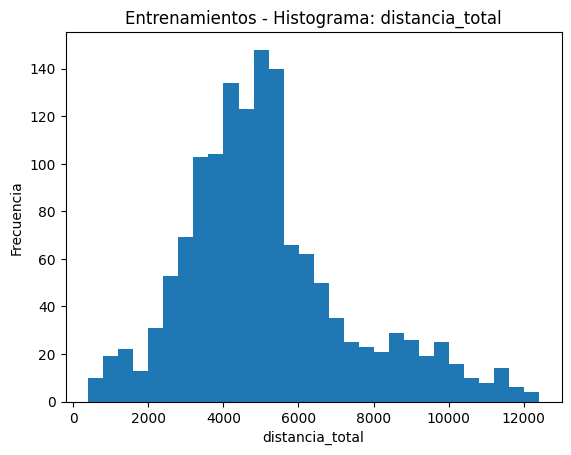

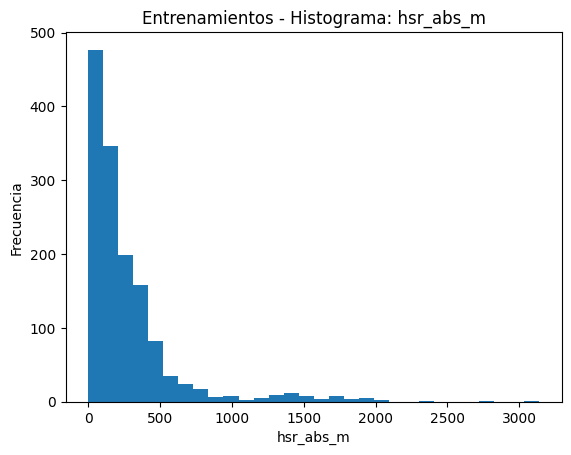

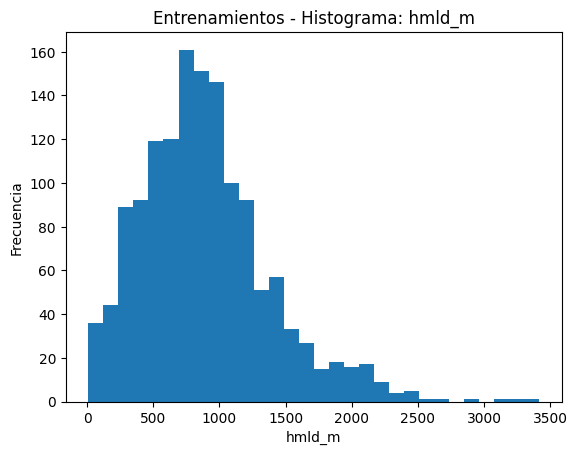

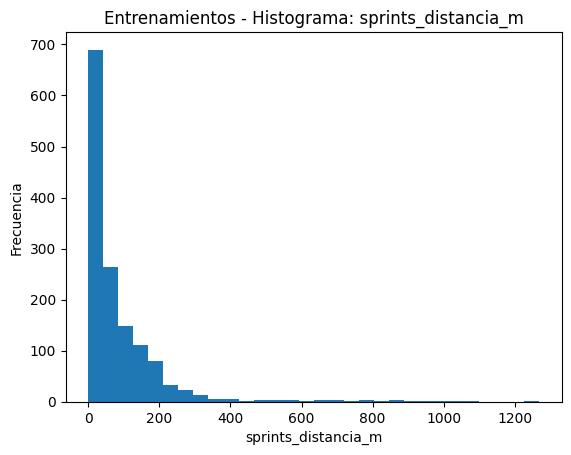

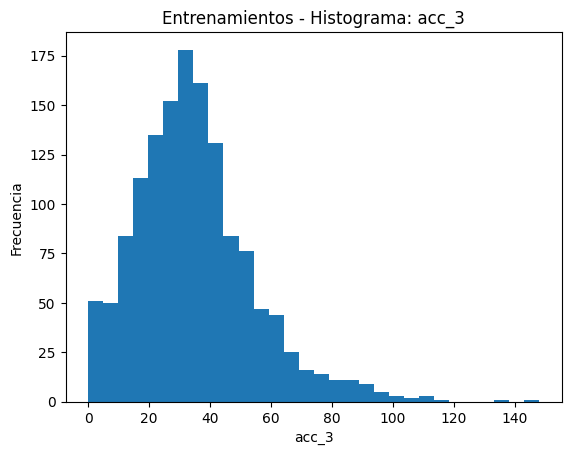

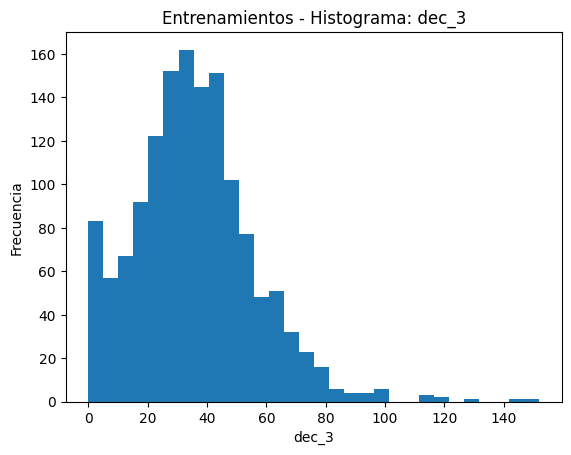

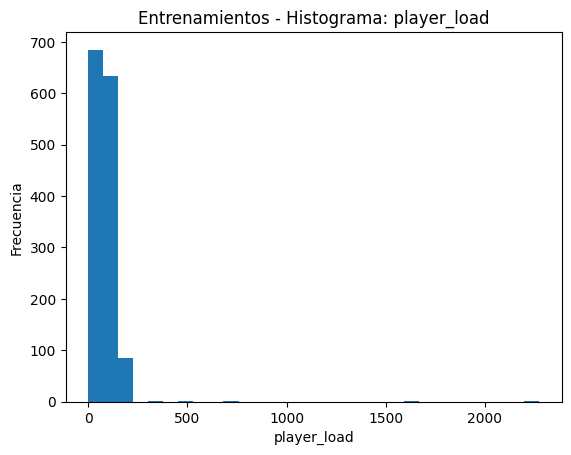

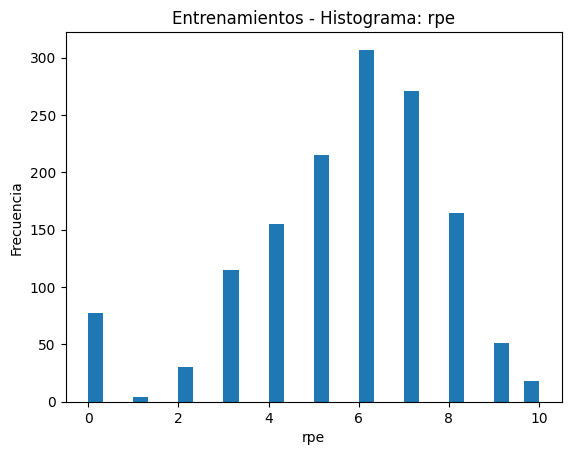

In [86]:
# Histogramas (primeras 8 columnas numéricas)
def plot_histograms(df, title_prefix, max_cols=8):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])][:max_cols]
    for c in num_cols:
        plt.figure()
        df[c].dropna().plot(kind='hist', bins=30)
        plt.title(f'{title_prefix} - Histograma: {c}')
        plt.xlabel(c)
        plt.ylabel('Frecuencia')
        plt.show()

plot_histograms(df_ent, 'Entrenamientos')

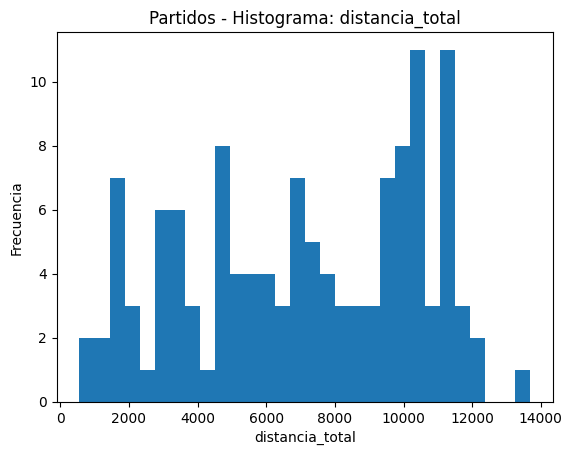

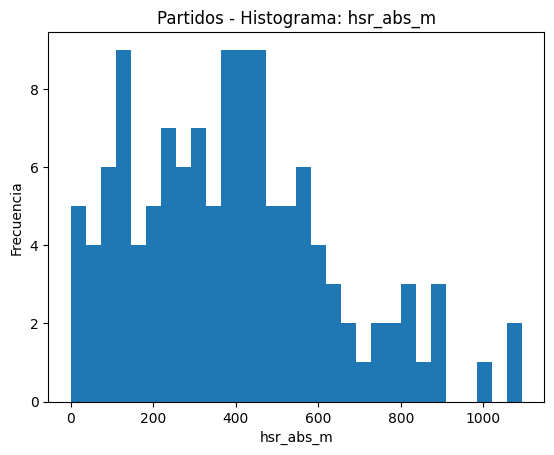

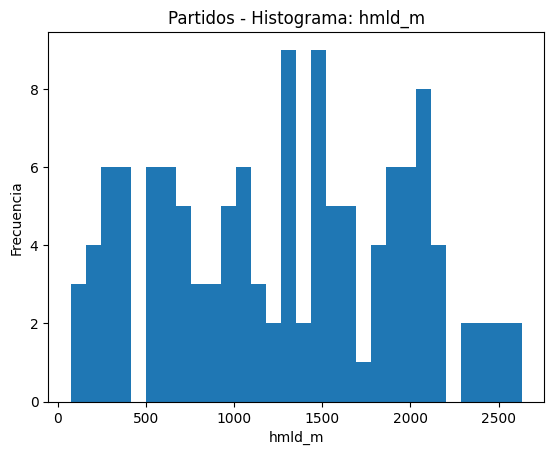

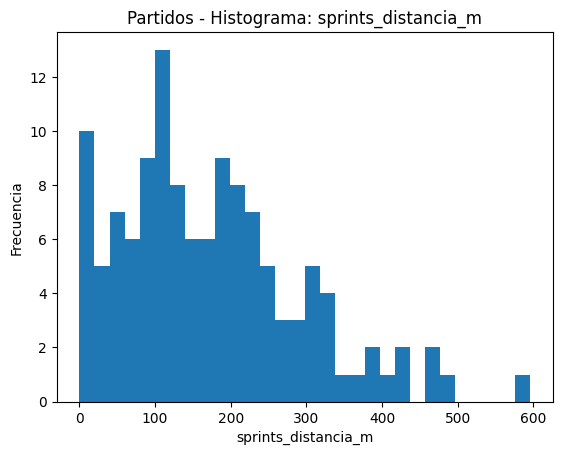

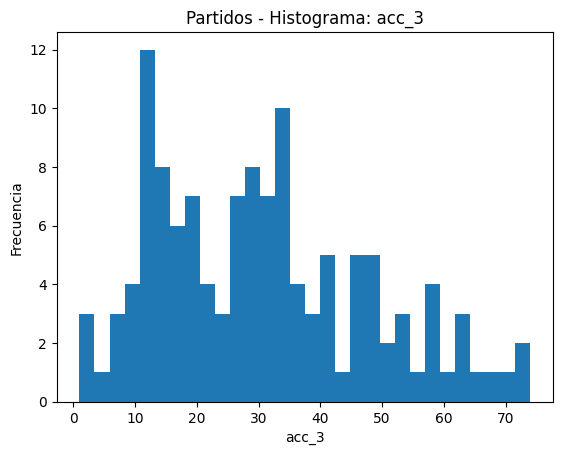

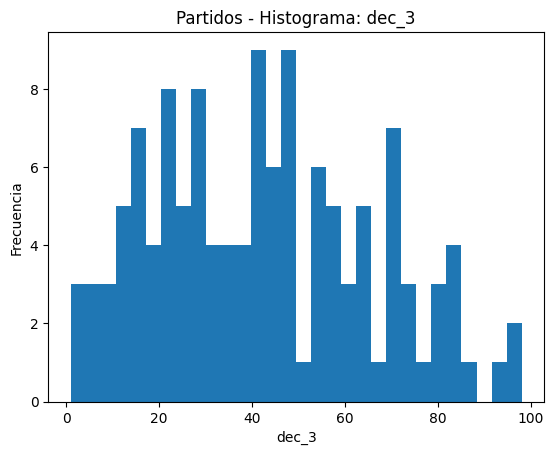

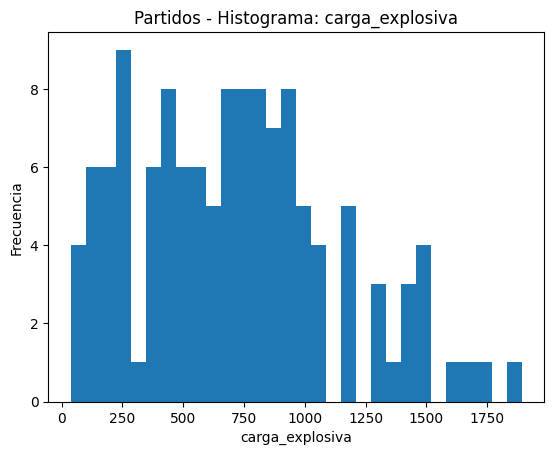

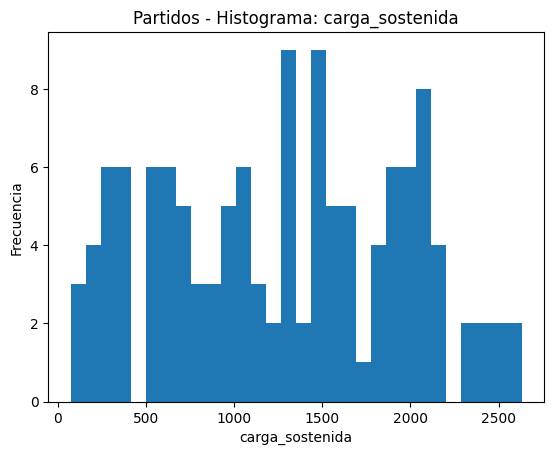

In [56]:
plot_histograms(df_par, 'Partidos')

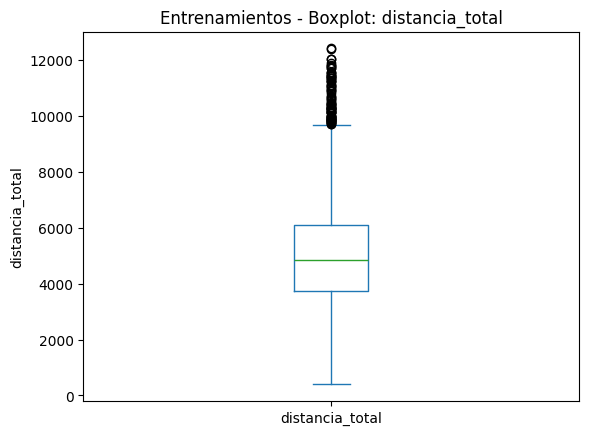

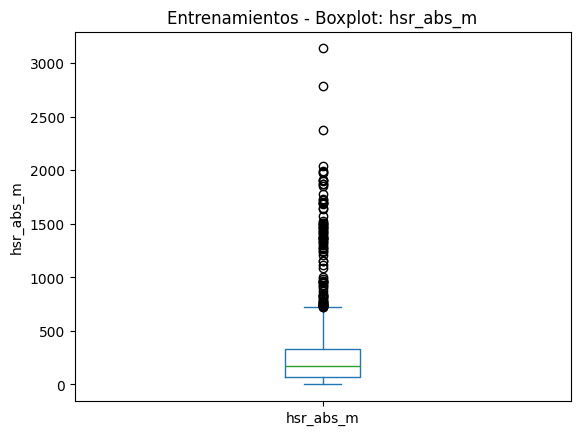

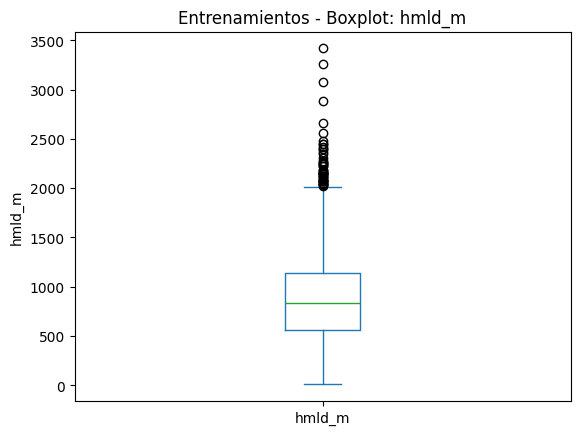

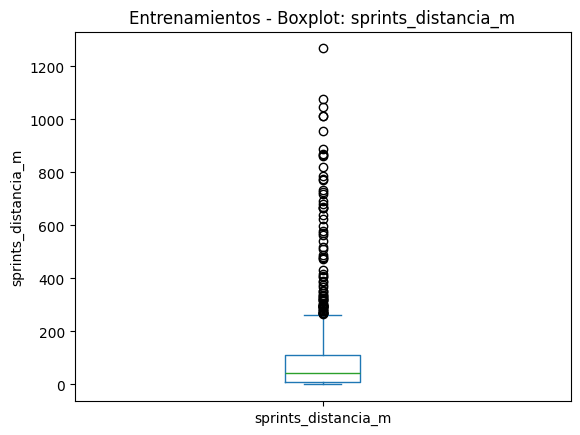

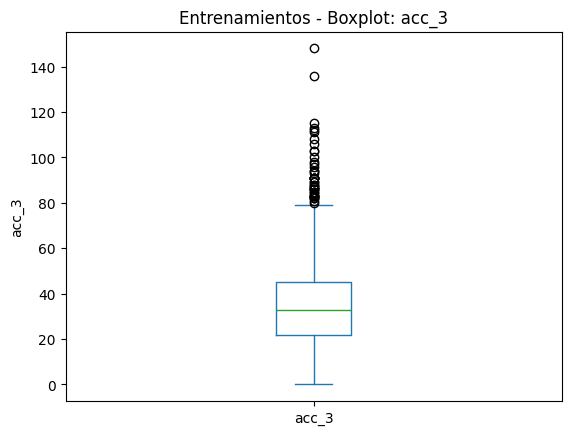

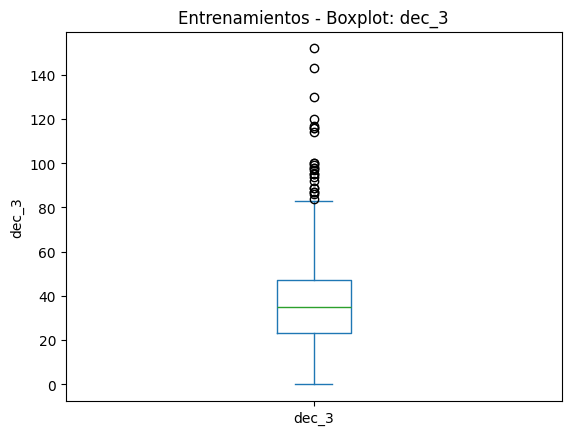

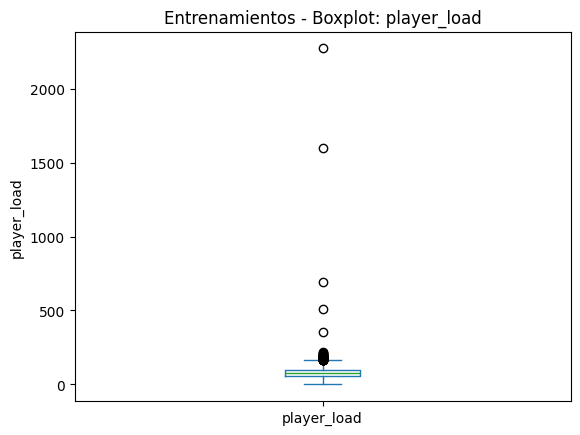

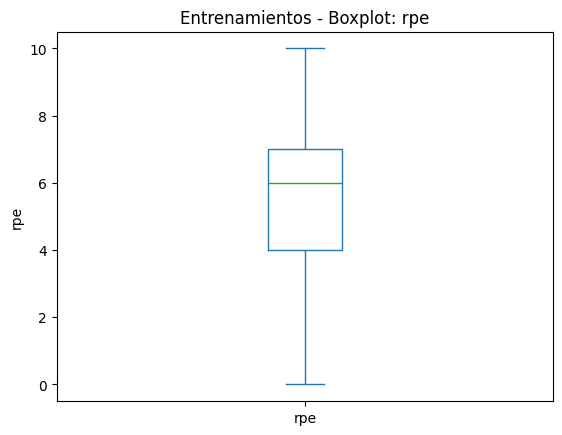

In [87]:
# Boxplots (primeras 8 columnas numéricas)
def plot_boxplots(df, title_prefix, max_cols=8):
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])][:max_cols]
    for c in num_cols:
        plt.figure()
        df[c].dropna().plot(kind='box')
        plt.title(f'{title_prefix} - Boxplot: {c}')
        plt.ylabel(c)
        plt.show()

plot_boxplots(df_ent, 'Entrenamientos')

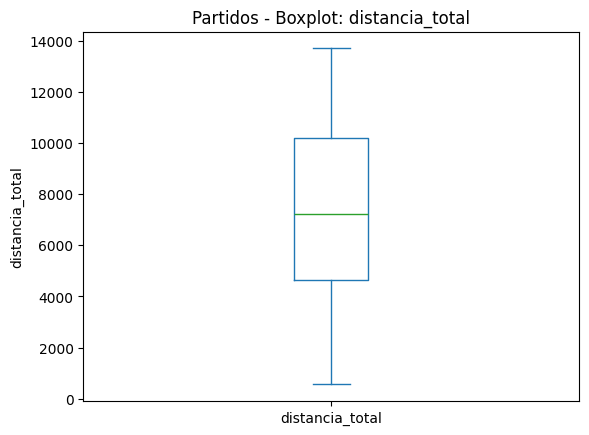

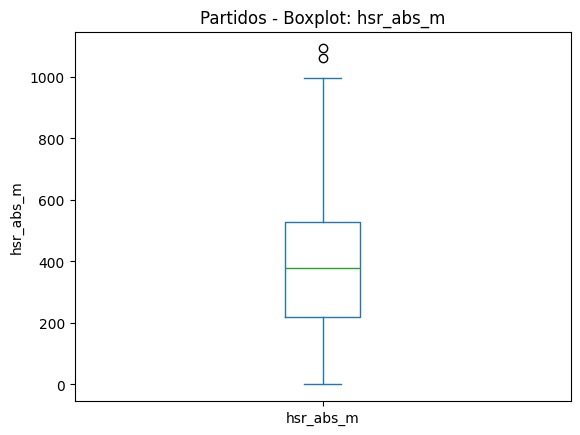

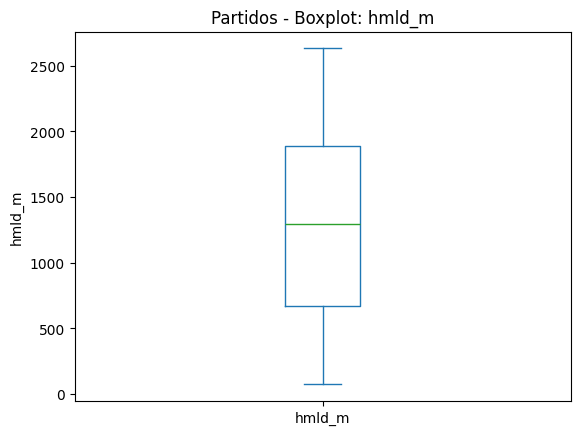

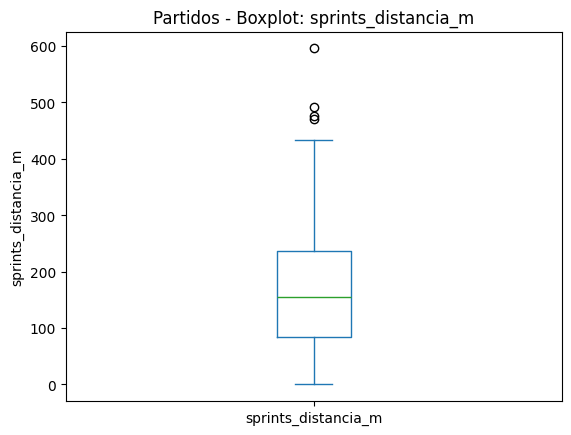

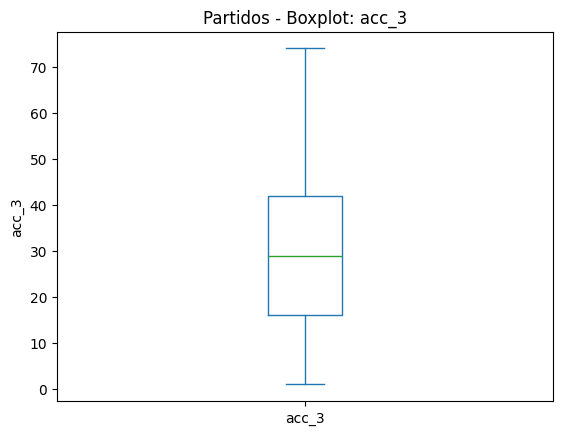

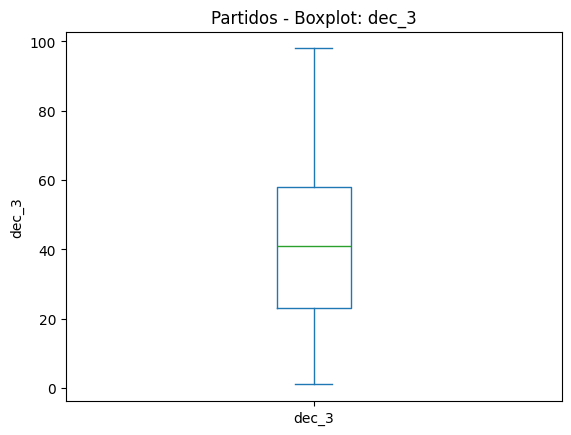

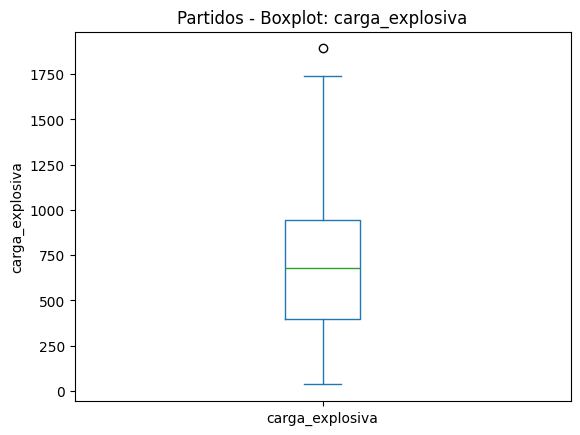

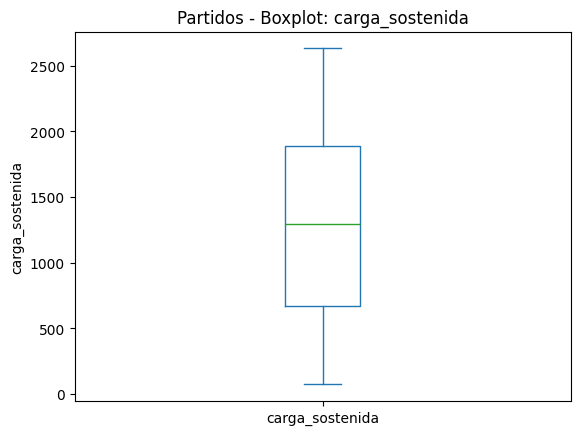

In [88]:
plot_boxplots(df_par, 'Partidos')

In [89]:
# Exportar reportes a CSV
out_dir = Path('.')
mr_ent.to_csv(out_dir / 'reporte_faltantes_entrenamientos.csv')
mr_par.to_csv(out_dir / 'reporte_faltantes_partidos.csv')
or_ent.to_csv(out_dir / 'reporte_outliers_entrenamientos.csv', index=False)
or_par.to_csv(out_dir / 'reporte_outliers_partidos.csv', index=False)
out_rows_ent.to_csv(out_dir / 'filas_outliers_entrenamientos.csv', index=False)
out_rows_par.to_csv(out_dir / 'filas_outliers_partidos.csv', index=False)
sorted([p.name for p in out_dir.glob('*.csv')])

['filas_outliers_entrenamientos.csv',
 'filas_outliers_partidos.csv',
 'reporte_faltantes_entrenamientos.csv',
 'reporte_faltantes_partidos.csv',
 'reporte_outliers_entrenamientos.csv',
 'reporte_outliers_partidos.csv']